First Steps: Guided Backpropagation

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import numpy as np
import matplotlib.pyplot as plt
input_path = "C:/DL_Lab/Racoon_dataset/train/"

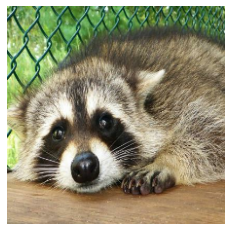

In [2]:
image = tf.io.read_file(input_path + "raccoon-20_jpg.rf.fb19aa368c074a61eed8829617ed6b7c.jpg")
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (224,224), method=tf.image.ResizeMethod.BILINEAR)
plt.imshow(image/255)
plt.axis("off")
image = preprocess_input(image)
image = np.expand_dims(image, axis=0)


In [3]:
@tf.custom_gradient
def guided_RELU(x):
    # forward pass
    y = tf.nn.relu(x)
    # custom gradient: 
    def grad(dy):
        # is gradient > 0?
        grad_mask = tf.cast(dy > 0,"float32")
        # is fwd pass activation > 0
        act_mask = tf.cast(x > 0, "float32")
        return grad_mask * act_mask * dy
    return y, grad

In [4]:
# pretrained model
model = ResNet50(include_top=False, weights="imagenet")

(-0.5, 223.5, 223.5, -0.5)

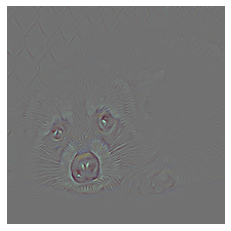

In [8]:
# go through all layers and replace relu with guided_relu
for layer in model.layers:
    if hasattr(layer, "activation"):
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guided_RELU

# get access to individual gradients
with tf.GradientTape() as tape:
  inputs = tf.cast(image, tf.float32)
  # ensures that tensor is being traced by this tape
  tape.watch(inputs)
  outputs = model(inputs)
# derive outputs by inputs
grads = tape.gradient(outputs, inputs)[0]

# scale to [0,1]
min = tf.math.reduce_min(grads)
max = tf.math.reduce_max(grads)
grads = (grads - min) / (max - min)
plt.imshow(grads)
plt.axis("off")

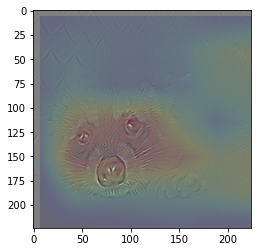

In [21]:
# guided backprop enhanced and cam overlayed
cam = tf.keras.utils.load_img("cam.png")
plt.imshow(cam)
plt.imshow(grads, alpha=0.9)

In [6]:
model = ResNet50(include_top=True, weights="imagenet")
pred = model(inputs)
print('Predicted:', decode_predictions(pred.numpy(), top=3)[0])

Predicted: [('n02447366', 'badger', 0.4357924), ('n02114367', 'timber_wolf', 0.091157295), ('n02443484', 'black-footed_ferret', 0.056702394)]


(-0.5, 223.5, 223.5, -0.5)

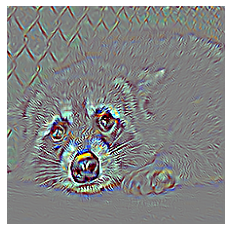

In [7]:
# this was copied from the keras repository, it enhances the picture
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

plt.imshow(deprocess_image(np.array(grads)))
plt.axis("off")

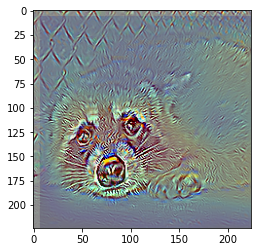

In [23]:
# guided backprop enhanced and cam overlayed
cam = tf.keras.utils.load_img("cam.png")
plt.imshow(cam)
plt.imshow(deprocess_image(np.array(grads)), alpha=0.9)